In [1]:
import json
import pickle as cPickle
import numpy as np

from sklearn import svm
from scipy.sparse import csr_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report
import random
import matplotlib.pyplot as plt

from collections import defaultdict
import math
from sklearn import preprocessing

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from scipy.stats import spearmanr
from sklearn import linear_model
import re
import copy

import seaborn as sns
import pandas as pd
import scipy.stats
import statsmodels.stats.proportion

from prediction_utils.show_examples import update, generate_snapshots, clean
from prediction_utils.features2vec import _get_term_features, _get_last_n_action_features, \
            _get_action_features, _get_repeatition_features, _get_balance_features, documents2feature_vectors

In [2]:
constraints = ['delta2_no_users_attacker_in_conv', 'delta2_no_users']
#constraints = ['delta2_none', 'delta2_no_users', 'delta3_none', 'delta3_no_users']
#constraints = ['none', 'no_users', 'attacker_in_conv', 'no_users_attacker_in_conv']

In [5]:
constraint = constraints[1]
suffix = '_verified'

In [6]:
UNIGRAMS_FILENAME = "/scratch/wiki_dumps/expr_with_matching/%s/bow_features/unigram100%s.pkl"%(constraint, suffix)
BIGRAMS_FILENAME = "/scratch/wiki_dumps/expr_with_matching/%s/bow_features/bigram200%s.pkl"%(constraint, suffix)
UNIGRAMS_LIST = cPickle.load(open(UNIGRAMS_FILENAME, "rb"))
BIGRAMS_LIST = cPickle.load(open(BIGRAMS_FILENAME, "rb"))

In [7]:
STATUS = {4: ['founder', 'sysop'], 
      3: ['accountcreator', 'bureaucrat', 'checkuser'], \
      2: [ 'abusefilter', 'abusefilter-helper', 'autoreviewer', 'extendedmover',  \
        'filemover', 'import', 'oversight', 'patroller', \
        'reviewer','rollbacker','templateeditor','epadmin', 'epcampus', 'epcoordinator',\
        'epinstructor', 'eponline'],\
      1: ['massmessage-sender', 'ipblock-exempt', 'extendedconfirmed',\
            'autoconfirmed', 'researcher', 'user']}
ASPECTS = ['age', 'status', 'comments_on_same_talk_page', 'comments_on_all_talk_pages',\
        'edits_on_subjectpage', 'edits_on_wikipedia_articles']

In [8]:
with open("/scratch/wiki_dumps/expr_with_matching/user_features/updated.json") as f:
    inp = json.load(f)
user_features = {}
for conv, users in inp:
    user_features[conv] = users

In [9]:
with open('feature_extraction/utils/lexicons') as f:
    LEXICONS = json.load(f)

In [36]:
def _user_features(document, user_features, ASPECTS, STATUS):
    EPS = 0.001

    actions = document['action_feature']
    end_time = 0
    start_time = np.inf
    for action in actions:
        if action['timestamp_in_sec'] > end_time:
            end_time = action['timestamp_in_sec'] 
        start_time = min(start_time, action['timestamp_in_sec'])

    users = []
    ret = {'has_anon': 0}
    for action in actions:
       # if action['timestamp_in_sec'] == end_time:
       #     continue
        if 'user_text' in action:
            users.append(action['user_text'])
        else:
            ret['has_anon'] = 1
            
    total = {}
    lst = {}

    for aspect in ASPECTS:
        ret['%s_gap'%aspect] = 0
        ret['min_%s'%aspect] = np.inf
        ret['max_%s'%aspect] = 0
        ret['%s_entropy'%aspect] = 1
        total[aspect] = 0
        lst[aspect] = []

    bot = ['bot']
    user_infos = {}
    for u in users:
        user_info = {}
        if u in user_features:
            user = user_features[u]
            if 'blocked' in user:
                ret['has_blocked'] = 1
                user_info['blocked'] = 1
            if 'registration' in user:
                user_info['age'] = max(0, (start_time - user['registration']) / 60 / 60 / 24 / 30)
            else:
                ret['has_anon'] = 1
                user_info['anon'] = 1
                user_info['age'] = 0
            level = 0
            if 'groups' in user:
                for g in user['groups']:
                    if g in bot:
                        ret['has_bot'] = 1
                        level = -1
                        break
                    for l in STATUS.keys():
                        if g in STATUS[l]:
                            level = max(level, l)
            if level >= 0:
                user_info['status'] = level
                user_info['comments_on_same_talk_page'] = user['edits_on_this_talk_page']
                user_info['comments_on_all_talk_pages'] = user['edits_on_wikipedia_talks']
                user_info['edits_on_subjectpage'] = user['edits_on_subjectpage']
                user_info['edits_on_wikipedia_articles'] = user['edits_on_wikipedia_articles']
            else:
                user_info['bot'] = 1
        else:
            ret['has_anon'] = 1
            user_info['anon'] = 1
          #  for aspect in ASPECTS:
          #      user_info['aspect'] = 0
        if 'status' in user_info:# and not('anon' in user_info): # is bot
            for aspect in ASPECTS:
                ret['max_%s'%aspect] = max(ret['max_%s'%aspect], user_info[aspect])
                ret['min_%s'%aspect] = min(ret['min_%s'%aspect], user_info[aspect])
                total[aspect] += user_info[aspect]
                lst[aspect].append(user_info[aspect])
        user_infos[u] = user_info
    for aspect in ASPECTS:
        if len(lst[aspect]):
            ret['%s_gap'%(aspect)] = ret['max_%s'%aspect] - ret['min_%s'%aspect]
            if len(lst[aspect]) > 1 and total[aspect]:
                l = len(lst[aspect])
                for x in lst[aspect]:
                    if x == 0:
                        a = EPS
                    else:
                        a = x
                ret['%s_entropy'%aspect] += a / total[aspect] * math.log(a / total[aspect]) / math.log(l)
        if np.isinf(ret['min_%s'%aspect]):
            ret['min_%s'%(aspect)] = 0
 #   print(ret['max_age'])
    return ret, user_infos

In [40]:
def attacker_profile(document, user_infos, collected, ASPECTS):
    actions = document['action_feature']
    end_time = 0
    start_time = np.inf
    attacker = None
    for action in actions:
        if action['timestamp_in_sec'] > end_time:
            end_time = action['timestamp_in_sec'] 
            if 'user_text' in action:
                attacker = action['user_text']
            else:
                attacker = None
        start_time = min(start_time, action['timestamp_in_sec'])
    appeared = False
    for action in actions:
        if action['timestamp_in_sec'] < end_time:
            if 'user_text' in action and action['user_text'] == attacker:
                appeared = True
    blocked = False
    profile = {}
    for aspect in ASPECTS:
        profile[aspect] = 0

    if attacker:
        profile = user_infos[attacker]
    cnts = {}
    for aspect in ASPECTS:
        if attacker == None or 'anon' in profile:
            cnts[aspect] = 'Anonymous'
            continue
        if not(appeared):
            cnts[aspect] = 'New Comer'
            continue
        if 'bot' in profile:
            cnts[aspect] = 'Bot'
            continue
        if collected['max_'+aspect] > collected['min_'+aspect]:
            if profile[aspect] == collected['min_'+aspect]:
                cnts[aspect] = 'Min'
            else:
                if profile[aspect] == collected['max_'+aspect]:
                    cnts[aspect] = 'Max'
                else:
                    cnts[aspect] = 'In the Middle'
        else:
            cnts[aspect] = 'No Gap'
        cnts['experience'] = profile['comments_on_all_talk_pages']
    return cnts, blocked

In [12]:
def train_svm(X, y):

    # For good luck

    print("Fitting")
    tuned_parameters = [#{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
                    {'C': [0.0001, 0.0003, 0.0005, 0.0007, 0.0009]}]
    linear_tuned_parameters = [#{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
                    {'C': [0.009, 0.001, 0.003, 0.005, 0.007]}]

    clf = GridSearchCV(svm.LinearSVC(), tuned_parameters, cv=5, scoring = 'accuracy')
    clf.fit(X, y)
    
    logreg = GridSearchCV(linear_model.LogisticRegression(), linear_tuned_parameters, cv=5, scoring= 'accuracy')
    logreg.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_estimator_)
    print()
    print("Grid scores on development set:")
    print()
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() / 2, params))
    print()
    
    for params, mean_score, scores in logreg.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() / 2, params))

#    print(scores.mean())
#    print scores

In [13]:
documents = []
with open('/scratch/wiki_dumps/expr_with_matching/%s/data/train%s.json'%(constraint, suffix)) as f:
    for line in f:
        conv_id, clss, conversation = json.loads(line)
        documents.append((conversation, clss, conv_id))       


In [14]:
random.shuffle(documents)

In [15]:
feature_sets = []
bow_features = []
for pair in documents:
    conversation, clss, conv_id = pair
    feature_set = {}
    feature_set.update(_get_term_features(conversation, UNIGRAMS_LIST, BIGRAMS_LIST))
    bow_features.append((copy.deepcopy(feature_set), clss))
    feature_set.update(_get_last_n_action_features(conversation, 3, LEXICONS))
    feature_set.update(_get_action_features(conversation, LEXICONS))
    feature_set.update(_get_repeatition_features(conversation))
    feature_set.update(_get_balance_features(conversation))
    feature_sets.append((feature_set, clss))

/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [16]:
conv_features = copy.deepcopy(feature_sets)

In [41]:
feature_sets = []
profiles = {0: [], 1:[]}
blocks = []
user_info = []
for ind, pair in enumerate(documents):
    conversation, clss, conv_id = pair
    feature_set, user_infos = _user_features(conversation, user_features[conv_id], ASPECTS, STATUS)
    p, b = attacker_profile(conversation,  user_infos, feature_set, ASPECTS)
    user_info.append(user_infos)
    profiles[clss].append(p)
    blocks.append(int(b))
    feature_set.update(conv_features[ind][0])
    feature_sets.append((feature_set, clss))

In [22]:
print('Percentage of attackers been blocked:', np.sum(blocks) / len(blocks))

Percentage of attackers been blocked: 0.0


In [25]:
X, y, feature_names = documents2feature_vectors(feature_sets)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000


In [26]:
train_svm(X, y)

Fitting
Best parameters set found on development set:

LinearSVC(C=0.0003, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

Grid scores on development set:

0.657 (+/-0.002) for {'C': 0.0001}
0.660 (+/-0.003) for {'C': 0.0003}
0.658 (+/-0.002) for {'C': 0.0005}
0.657 (+/-0.002) for {'C': 0.0007}
0.656 (+/-0.001) for {'C': 0.0009}

0.656 (+/-0.002) for {'C': 0.009}
0.658 (+/-0.002) for {'C': 0.001}
0.660 (+/-0.003) for {'C': 0.003}
0.659 (+/-0.003) for {'C': 0.005}
0.657 (+/-0.002) for {'C': 0.007}


/home/yiqing/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/home/yiqing/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


# Ploting Utilities

In [30]:
def plot_profiles(profiles, clss, ASPECTS):
    catergories = {'Min': 0, 'Max': 1, 'In the Middle': 2, 'Anonymous':3, 'New Comer':4, 'No Gap': 5, 'Bot': 6}
    cats = ['Min', 'Max', 'In the Middle', 'Anonymous', 'New Comer']

    f, ax = plt.subplots(1, figsize=(10,6))
    bar_width = 0.4
    bar_l = [i for i in range(len(ASPECTS))] 
    tick_pos = [i+0.2 for i in bar_l]

    colors = ['pink', 'mediumslateblue', 'steelblue', 'mediumaquamarine', 'darksalmon']
    bads = [[[], [], [], [], [], [], []], [[], [], [], [], [], [], []]]
    total = len(profiles[0])
    alpha=[0.9, 0.3]
    conv_label = ['bad_', 'good_']
    for clss in [0, 1]:
        for aspect in ASPECTS:
            for ind in range(len(catergories)):
                bads[clss][ind].append(0)
            for p in profiles[clss]:
                bads[clss][catergories[p[aspect]]][-1] += 1
        previous = [0 for a in ASPECTS]
        for ind,bad in enumerate(bads[clss][:3]):
            bad = [b / total for b in bad]
            bads[clss][ind] = bad
            ax.bar(bar_l, bad, label=conv_label[clss] + cats[ind], bottom = previous, alpha=alpha[clss], \
                color=colors[ind],width=bar_width,edgecolor='white')
            for ii, b in enumerate(bad):
                previous[ii] += b
        ax.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize='small')
        bar_l = [b+bar_width for b in bar_l]
        

    ax.set_ylabel("Percentage among All the Cases")
    ax.set_xlabel("Aspect")
    Xticks = ['Age', 'Community Social Status', 'Experience on the Current Talk Page', \
              'Experience on the All Talk Pages', 'Edits on the Subject Page', \
              'Edits on All Pages']
    plt.xticks(tick_pos, Xticks)
  #  ax.set_xlabel("")

    # rotate axis labels
    plt.setp(plt.gca().get_xticklabels(), rotation=25, horizontalalignment='right')
    plt.title('Who\'s the Attacker')

    # shot plot
    plt.show()

In [31]:
def autolabel(rects, ax):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%.2f' % height,
                ha='center', va='bottom')

In [32]:
def plot_profiles1(profiles, clss, ASPECTS, experience=-1):
    catergories = {'Min': 0, 'Max': 1, 'In the Middle': 2, 'Anonymous':3, 'New Comer':4, 'No Gap': 5, 'Bot': 6}
    cats = ['Min', 'Max', 'In the Middle', 'Anonymous', 'New Comer']

    f, ax = plt.subplots(1, figsize=(10,6))
    bar_width = 0.4
    bar_l = [i for i in range(len(ASPECTS))] 
    tick_pos = [i+0.2 for i in bar_l]

    colors = ['pink', 'mediumslateblue', 'steelblue', 'mediumaquamarine', 'darksalmon']
    bads = [[[], [], [], [], [], [], []], [[], [], [], [], [], [], []]]
    total = len(profiles[0])
    alpha=[0.9, 0.3]
    conv_label = ['bad_', 'good_']
    mins = [[], []]
    cnts = [[[], [], [], [], [], [], []], [[], [], [], [], [], [], []]]
    rects = []
    for clss in [0, 1]:
        for aspect in ASPECTS:
            cur = []
            for ind in range(len(catergories)):
                bads[clss][ind].append(0)
                cnts[clss][ind].append(0)
            for p in profiles[clss]:
                if not('experience') in p or p['experience'] <= experience:
                    continue
                bads[clss][catergories[p[aspect]]][-1] += 1
                cnts[clss][catergories[p[aspect]]][-1] += 1
                if catergories[p[aspect]] == 0:
                    cur.append(1)
                else:
                    cur.append(0)
            mins[clss].append(cur)
        previous = [0 for a in ASPECTS]
        first_three = [0 for a in ASPECTS]
        for bad in bads[clss][:3]:
            for ii, b in enumerate(bad):
                first_three[ii] += b
        for ind,bad in enumerate(bads[clss][:3]):
            for ii, b in enumerate(bad):
                bad[ii] = bad[ii] / first_three[ii]
            bads[clss][ind] = bad
            rects = ax.bar(bar_l, bad, label=conv_label[clss] + cats[ind], bottom = previous, alpha=alpha[clss], \
                color=colors[ind],width=bar_width,edgecolor='white')
            for ind, rect in enumerate(rects):
                ax.text(rect.get_x() + rect.get_width()/2., (bad[ind] / 3 + previous[ind]),
                '%.2f' % bad[ind],
                ha='center', va='bottom')
            for ii, b in enumerate(bad):
                previous[ii] += b
        ax.legend(loc="upper left", bbox_to_anchor=(1,1), fontsize='small')
        bar_l = [b+bar_width for b in bar_l]
    ax.set_ylabel("Percentage among All the Cases")
    ax.set_xlabel("Aspect")
    Xticks = ['Age', 'Community Social Status', 'Experience on the Current Talk Page', \
              'Experience on the All Talk Pages', 'Edits on the Subject Page', \
              'Edits on All Pages']

    plt.xticks(tick_pos, Xticks)
  #  ax.set_xlabel("")

    # rotate axis labels
    plt.setp(plt.gca().get_xticklabels(), rotation=25, horizontalalignment='right')
    plt.title('Who\'s the Attacker')

    # shot plot
    plt.show()
    for aspect in ASPECTS:
        print(aspect, first_three[0], first_three[1])

    print('Test 1')
    for ind, aspect in enumerate(ASPECTS):
        print(aspect)
        print('Average in Ggap: ', np.mean(mins[1][ind]))
        print('Average of Bgap: ', np.mean(mins[0][ind]))
        print(scipy.stats.mannwhitneyu(mins[0][ind], mins[1][ind]))
        print('\n')
    print('Test 2')
    clss = 0
    for ind, aspect in enumerate(ASPECTS):
        print(aspect, ':', scipy.stats.binom_test(cnts[clss][0][ind], cnts[clss][0][ind] + cnts[clss][1][ind]))
     #   print(cnts[clss][0][ind], cnts[clss][1][ind])
    print('\n')
    print('Test 3')
    clss = 1
    for ind, aspect in enumerate(ASPECTS):
        print(aspect, ':', scipy.stats.binom_test(cnts[clss][0][ind], cnts[clss][0][ind] + cnts[clss][1][ind]))
    

/home/yiqing/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


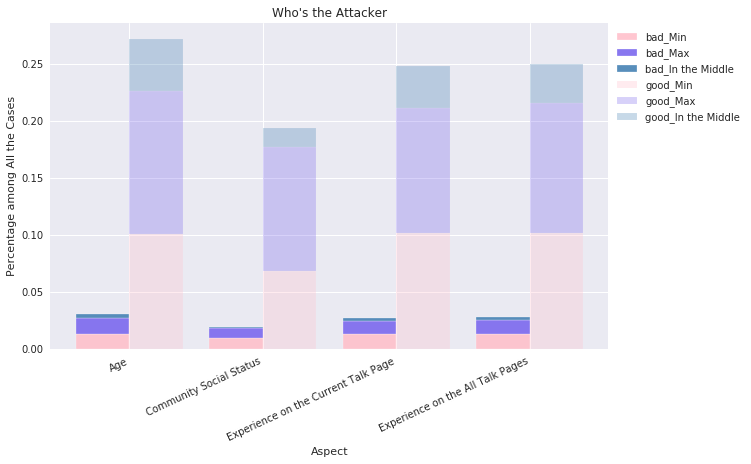

In [42]:
plot_profiles(profiles, 1, ['age', 'status', 'comments_on_all_talk_pages',\
        'edits_on_wikipedia_articles'])

/home/yiqing/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


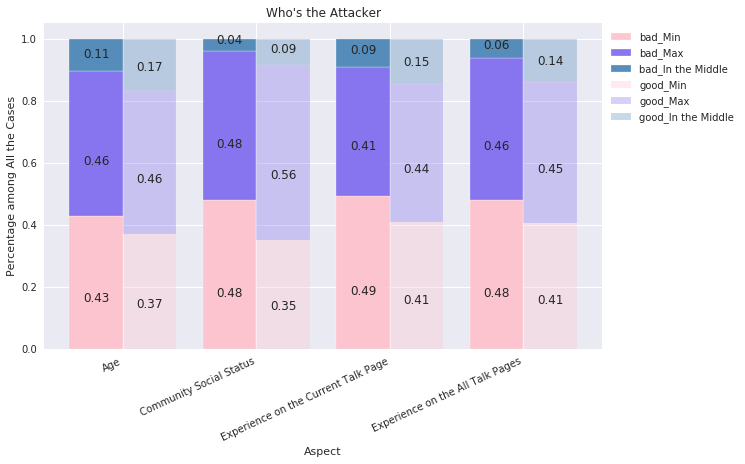

age 2012 1433
status 2012 1433
comments_on_all_talk_pages 2012 1433
edits_on_wikipedia_articles 2012 1433
Test 1
age
Average in Ggap:  0.269493352497
Average of Bgap:  0.418803418803
MannwhitneyuResult(statistic=276994.0, pvalue=5.3293400361975168e-07)


status
Average in Ggap:  0.181458857348
Average of Bgap:  0.299145299145
MannwhitneyuResult(statistic=287291.0, pvalue=5.3768839988240207e-06)


comments_on_all_talk_pages
Average in Ggap:  0.270930650377
Average of Bgap:  0.423076923077
MannwhitneyuResult(statistic=276070.5, pvalue=3.4727306332659913e-07)


edits_on_wikipedia_articles
Average in Ggap:  0.270571325907
Average of Bgap:  0.423076923077
MannwhitneyuResult(statistic=275953.5, pvalue=3.2393493499202267e-07)


Test 2
age : 0.624173185045
status : 1.0
comments_on_all_talk_pages : 0.266142029243
edits_on_wikipedia_articles : 0.773491141695


Test 3
age : 2.31733961478e-05
status : 8.66069219223e-17
comments_on_all_talk_pages : 0.171955148495
edits_on_wikipedia_articles : 0.031

In [43]:
plot_profiles1(profiles, 1, ['age', 'status', 'comments_on_all_talk_pages',\
        'edits_on_wikipedia_articles'])

/home/yiqing/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


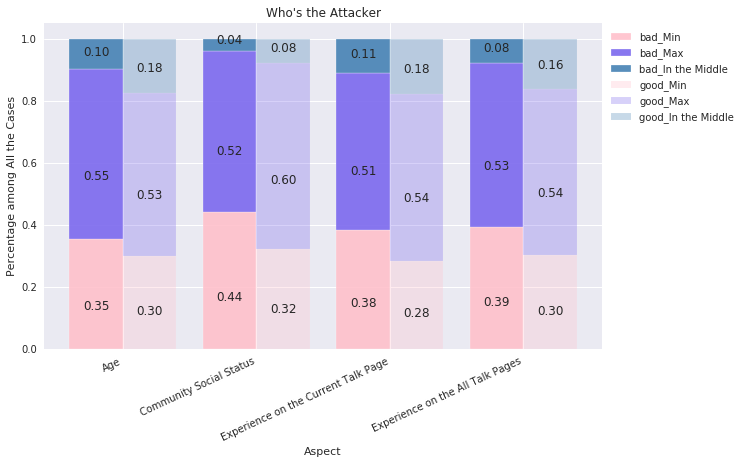

age 1506 1047
status 1506 1047
comments_on_all_talk_pages 1506 1047
edits_on_wikipedia_articles 1506 1047
Test 1
age
Average in Ggap:  0.215996168582
Average of Bgap:  0.353658536585
MannwhitneyuResult(statistic=147646.0, pvalue=2.4785705838305624e-05)


status
Average in Ggap:  0.162356321839
Average of Bgap:  0.280487804878
MannwhitneyuResult(statistic=150990.0, pvalue=5.4784045802608569e-05)


comments_on_all_talk_pages
Average in Ggap:  0.205938697318
Average of Bgap:  0.384146341463
MannwhitneyuResult(statistic=140704.0, pvalue=5.3924995084654196e-08)


edits_on_wikipedia_articles
Average in Ggap:  0.215517241379
Average of Bgap:  0.390243902439
MannwhitneyuResult(statistic=141300.0, pvalue=1.4303629708912052e-07)


Test 2
age : 0.0105826434029
status : 0.484118413607
comments_on_all_talk_pages : 0.115539710252
edits_on_wikipedia_articles : 0.086071103186


Test 3
age : 3.67008618367e-22
status : 1.35981345257e-20
comments_on_all_talk_pages : 2.64136182364e-27
edits_on_wikipedia_a

In [44]:
plot_profiles1(profiles, 1, ['age', 'status', 'comments_on_all_talk_pages',\
        'edits_on_wikipedia_articles'], 0)

/home/yiqing/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


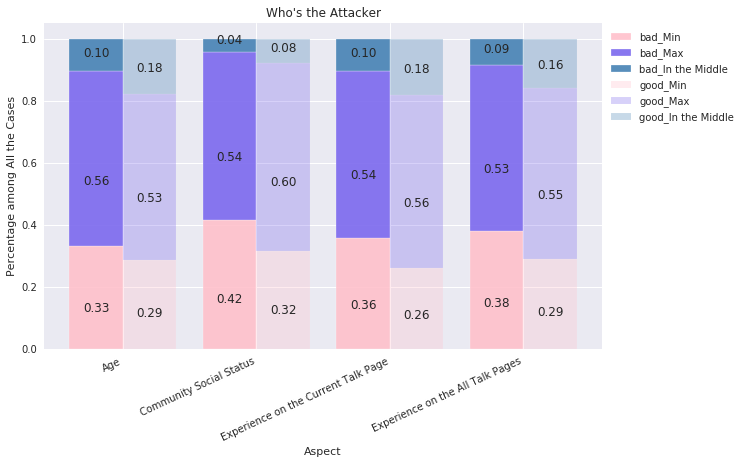

age 1382 959
status 1382 959
comments_on_all_talk_pages 1382 959
edits_on_wikipedia_articles 1382 959
Test 1
age
Average in Ggap:  0.207941483804
Average of Bgap:  0.333333333333
MannwhitneyuResult(statistic=128061.0, pvalue=0.00014816578325557882)


status
Average in Ggap:  0.158307210031
Average of Bgap:  0.261437908497
MannwhitneyuResult(statistic=131320.5, pvalue=0.00048570891969643067)


comments_on_all_talk_pages
Average in Ggap:  0.189655172414
Average of Bgap:  0.359477124183
MannwhitneyuResult(statistic=121555.5, pvalue=2.4375555359398886e-07)


edits_on_wikipedia_articles
Average in Ggap:  0.206896551724
Average of Bgap:  0.37908496732
MannwhitneyuResult(statistic=121209.0, pvalue=3.7266021517668413e-07)


Test 2
age : 0.00351999328744
status : 0.251322103475
comments_on_all_talk_pages : 0.0259668373227
edits_on_wikipedia_articles : 0.0616493425108


Test 3
age : 2.98730653179e-24
status : 7.55830254033e-21
comments_on_all_talk_pages : 3.25317772329e-34
edits_on_wikipedia_art

In [45]:
plot_profiles1(profiles, 1, ['age', 'status', 'comments_on_all_talk_pages',\
        'edits_on_wikipedia_articles'], 5)

In [46]:
def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors, alpha=0.5)
    names = np.array(feature_names)
    plt.xticks(np.arange(0, 2 * top_features), names[top_coefficients], rotation=60, ha='right')
    plt.title('Top Positive and Negative Features')
    plt.show()
    return list(names[top_positive_coefficients]), list(names[top_negative_coefficients])

In [47]:
def plot_feature_distribution(all_features, features):
    cnts = {}
    for f in features:
        cnts[f] = {0:[], 1:[]}

    for pair in all_features:
        fea, clss = pair
        for f in fea.keys():
            if f in features:
                cnts[f][clss].append(fea[f])
    
    print('finish collecting')
    means_0 = []
    means_1 = []
    stds_0 = []
    stds_1 = []
    for f in features:
        means_0.append(np.mean(cnts[f][0]))
        means_1.append(np.mean(cnts[f][1]))
        stds_0.append(np.std(cnts[f][0]))
        stds_1.append(np.std(cnts[f][1]))
    
    
    N = len(features)
    
    ind = np.arange(N)  # the x locations for the groups
    width = 0.35       # the width of the bars

    plt.figure(figsize=(15, 5))
    rects1 = plt.bar(ind, means_0, width, color='r', yerr=stds_0)

    rects2 = plt.bar(ind + width, means_1, width, color='y', yerr=stds_1)

    # add some text for labels, title and axes ticks
  #  plt.set_ylabel('Average')
    plt.title('Predictive Features by group')
    plt.xticks(ind + width / 2, features, rotation=60, ha='right')
 #   plt.set_xticklabels(features)

    plt.legend((rects1[0], rects2[0]), ('Bad Conversation', 'Good Conversations'))

    plt.show()

In [48]:
def get_examples(documents, pairs, the_feature, the_value, number, wanted_class, answer):
    conversations = {}
    for ind, doc in enumerate(documents):
        conversation, clss, conv_id = doc
        conversations[conv_id] = ind

    for ind, pair in enumerate(pairs):
        fea, clss = pair
        conversation, clss, conv_id = documents[ind]
        if clss:
            matched_id = conversation['action_feature'][0]['bad_conversation_id']
        else:
            matched_id = conversation['action_feature'][0]['good_conversation_id']
        the_match = conversations[matched_id]
        for f in fea.keys():
            if f == the_feature and fea[f] >= the_value and clss == wanted_class and \
                pairs[the_match][0][f] < the_value and answer[ind] == clss and \
                answer[the_match] == 1 - clss:
                number -= 1
                for ii in [ind, the_match]:
                    actions = sorted(documents[ii][0]['action_feature'], \
                                 key=lambda k: (k['timestamp_in_sec'], k['id'].split('.')[1], k['id'].split('.')[2]))
                    end_time = max([a['timestamp_in_sec'] for a in actions])
                    actions = [a for a in actions if a['timestamp_in_sec'] < end_time]
                    snapshot = generate_snapshots(actions)
                    the_action = {}
                    for a in actions:
                        the_action[a['id']] = a
                    if number == 0:
                        print(actions[0]['conversation_id'])
                        print(pairs[ii][0][f])
                        for s in snapshot:
                          #  print(the_action[s['id']]['content_words'])
                            print(s['content'])
                            print(s['user_text'])
                            print(s['relative_replyTo'])
                            print(the_action[s['id']]['pron_you'])
                        print('\n')
                if number == 0:
                    return

In [109]:
classifier = linear_model.LogisticRegression(C=0.009)
classifier.fit(X, y)
ans = classifier.predict(X)
#get_examples(documents, feature_sets, 'has_content_repeat', 1, 3, 1, ans)
get_examples(documents, feature_sets, 'user_last_action_LEXICON_pron_you', 1, 27, 0, ans)

98582250.947.947
1
 == Name ==
Discharger12
-1
0
 The band's name is in all caps.
Discharger12
0
0
You're right. I'm pretty sure. Should we move the article? I'll wait a few days and move it to [DAUGHTRY (band)] if there aren't any objections. - 
Anas Salloum
1
1


98636719.972.972
0
 == City? ==
Chanlyn
-1
0
 Is the band based in any particular NC city? Raleigh, Durham, Burlington, Greensboro? ([special:emailuser/Pink moon1287@email]•[talk]•[user])
Chanlyn
0
0
 Well he was in North Carolina before American Idol so I guess if we can find out the hometown of him that should be the city of origin. Because after he was voted off he went back to his band in his hometown.-
Weatherman289
0
0
 I added the city or origin. McLeansville is the city. PLEASE IF YOU HAVE ANY DIFFERENT INFORMATION PLEASE TALK ABOUT IT FIRST.
Weatherman289
0
1




In [49]:
def get_tile(num, tiles):
    for ind, t in enumerate(tiles):
        if num <= t:
            return ind

In [50]:
def get_values(aspect, feature_sets):
    values = []
    for pair in feature_sets:
        f, clss = pair
        values.append(f['min_%s'%(aspect)])
        values.append(f['max_%s'%(aspect)])
    values = np.array(values)
    return values

In [51]:
def discrepancy_heatmap_total(aspect, feature_sets, tiles, tile_legends, no_anon=False):
    total_d = []
    data = []
    total_t = len(tiles)
    for v in range(total_t):
        cur = []
        cur_d = []
        for v1 in range(total_t):
            cur.append(0)
            cur_d.append(0)
        data.append(cur)
        total_d.append(cur_d)
    for pair in feature_sets:
        f, clss = pair
        mini = get_tile(f['min_%s'%aspect], tiles)
        maxi = get_tile(f['max_%s'%aspect], tiles)
   #     print(mini,maxi, tiles)
        data[mini][maxi] += clss
        total_d[mini][maxi] += 1
    for v in range(total_t):
        for v1 in range(total_t):
            if total_d[v][v1]:
                data[v][v1] /= total_d[v][v1]
    plt.figure(figsize=(10, 8))
    sns.heatmap(total_d[::-1], annot=True)
    #sns.heatmap(data[::-1], annot=True)
    plt.ylabel('Min')
    plt.xlabel('Max')
    plt.yticks([v + 0.5 for v in range(total_t)], tile_legends, rotation=60)
    plt.xticks([v + 0.75 for v in range(total_t)], tile_legends, rotation=60)
    plt.show()

In [52]:
aspect = 'age'
convs = {}
deleted = {}
good = []
bad = []
good_ages = []
bad_ages = []
for ind, pair in enumerate(feature_sets):
# No anonymous in the conversation
    f, clss = pair
    conversation, clss, conv_id = documents[ind]
    action = conversation['action_feature'][0]
    if f['has_anon'] == 1:
        deleted[conv_id] = 1
        if clss:
            deleted[action['bad_conversation_id']] = 1
        else:
            deleted[action['good_conversation_id']] = 1   
print(len(deleted))
for ind, pair in enumerate(feature_sets):
# No anonymous in the conversation
    f, clss = pair
    conversation, clss, conv_id = documents[ind]
    if conv_id in deleted:
        continue
    if clss:
        good.append(f['max_%s'%aspect] - f['min_%s'%aspect])
    else:
        bad.append(f['max_%s'%aspect] - f['min_%s'%aspect]) 
    for user in user_info[ind].keys():
        if clss and 'age' in user_info[ind][user]:
            good_ages.append(user_info[ind][user][aspect])
        else:
            bad_ages.append(user_info[ind][user][aspect])

10184


In [ ]:
# average age

In [54]:
print(len(good), len(bad))

2312 2312


In [53]:
print(np.mean(good), np.mean(bad), scipy.stats.wilcoxon(good, bad))
print(np.mean(good_ages), np.mean(bad_ages), scipy.stats.mannwhitneyu(good_ages, bad_ages))

17.9484820857 19.1208319009 WilcoxonResult(statistic=1212508.0, pvalue=0.00023897272847940777)
25.2487973403 24.3495755045 MannwhitneyuResult(statistic=13409441.5, pvalue=0.00041701113714994533)


In [55]:
def discrepancy_heatmap(aspect, feature_sets, tiles, tile_legends, no_anon=False):
    total_d = []
    data = []
    total_t = len(tiles)
    for v in range(total_t):
        cur = []
        cur_d = []
        for v1 in range(total_t):
            cur.append(0)
            cur_d.append(0)
        data.append(cur)
        total_d.append(cur_d)

    for pair in feature_sets:
        f, clss = pair
        mini = get_tile(f['min_%s'%aspect], tiles)
        maxi = get_tile(f['max_%s'%aspect], tiles)
   #     print(mini,maxi, tiles)

        data[mini][maxi] += 1-clss
        total_d[mini][maxi] += 1
    for v in range(total_t):
        for v1 in range(total_t):
            if total_d[v][v1] < 50:
                data[v][v1] = np.nan
            else:
                data[v][v1] /= total_d[v][v1]
    plt.figure(figsize=(10, 8))
    #sns.heatmap(total_d[::-1], annot=True)
    mask=np.isnan(data[::-1])
    sns.heatmap(data[::-1], annot=True, mask=mask)
    plt.ylabel('Min')
    plt.xlabel('Max')
    plt.yticks([v + 0.5 for v in range(total_t)], tile_legends, rotation=60)
    plt.xticks([v + 0.75 for v in range(total_t)], tile_legends, rotation=60)
    plt.show()
    return data

In [56]:
def discrepancy_heatmap_status(aspect, feature_sets, tiles, tile_legends, no_anon=False):
    total_d = []
    data = []
    total_t = len(tiles)
    for v in range(total_t):
        cur = []
        cur_d = []
        for v1 in range(total_t):
            cur.append(0)
            cur_d.append(0)
        data.append(cur)
        total_d.append(cur_d)
    normal_vs_normal = []
    normal_vs_all_admins = []
    normal_vs_page_admins = []
    for pair in feature_sets:
        f, clss = pair
        mini = get_tile(f['min_%s'%aspect], tiles)
        maxi = get_tile(f['max_%s'%aspect], tiles)
   #     print(mini,maxi, tiles)
        if mini == 1 and maxi == 1:
            normal_vs_normal.append(1-clss)
        if mini == 1 and maxi > 1:
            normal_vs_all_admins.append(1-clss)
        data[mini][maxi] += 1-clss
        total_d[mini][maxi] += 1
    for v in range(total_t):
        for v1 in range(total_t):
            if total_d[v][v1] < 50:
                data[v][v1] = np.nan
            else:
                data[v][v1] /= total_d[v][v1]
    plt.figure(figsize=(10, 8))
    #sns.heatmap(total_d[::-1], annot=True)
    mask=np.isnan(data[::-1])
    sns.heatmap(data[::-1], annot=True, mask=mask)
    plt.ylabel('Min')
    plt.xlabel('Max')
    plt.yticks([v + 0.5 for v in range(total_t)], tile_legends, rotation=60)
    plt.xticks([v + 0.75 for v in range(total_t)], tile_legends, rotation=60)
    plt.show()
    return data, normal_vs_normal, normal_vs_all_admins

In [57]:
# propencity of attacking
def propencity_of_attacking(aspect, user_infos, documents, tiles, tile_legends, feature_sets):
    data = []
    total_d = []
    total_t = len(tiles)
    the_attacker = []
    for v in range(total_t):
        cur = []
        cur_d = []
        for v1 in range(total_t):
            cur.append(0)
            cur_d.append(0)
        data.append(cur)
        total_d.append(cur_d)
        the_attacker.append([])
    for ind, pair in enumerate(documents):
        f, clss, conv_id = pair
        actions = f['action_feature']
        end_time = max([a['timestamp_in_sec'] for a in actions])
        attacker = None
        for a in actions:
            if a['timestamp_in_sec'] == end_time:
                if 'user_text' in a:
                    if aspect in user_info[ind][a['user_text']]:
                        last = user_info[ind][a['user_text']][aspect]
                        attacker = a['user_text']
                    else:
                        if 'bot' in user_info:
                            last = 'bot'
                        else:
                            last = None
                else:
                    last = None
                break
        if last == None or isinstance(last, str): 
            global_rank = 0
          #  if  last == 'bot':
            local_rank = 4
        else:
            global_rank = get_tile(last, tiles)
            vals = []
            appeared = False
            for a in actions:
                if a['timestamp_in_sec'] < end_time and 'user_text' in a and aspect in user_info[ind][a['user_text']]:
                    vals.append(user_info[ind][a['user_text']][aspect])
                    if a['user_text'] == attacker:
                        appeared = True
            #'Min', 'Max', 'In the middle', 'Anonymous', 'New Comer', 'Bot'
            if not(appeared): 
                local_rank = 3
            elif last == min(vals):
                local_rank = 0
            elif last == max(vals):
                local_rank = 1
            else:
                local_rank = 2
        the_attacker[global_rank].append(1-clss)
        maxi = get_tile(feature_sets[ind][0]['max_%s'%aspect], tiles)
        data[global_rank][maxi] += (1-clss)
        total_d[global_rank][maxi] += 1
    for v in range(total_t):
        for v1 in range(total_t):
            if total_d[v][v1] < 50:
                data[v][v1] = np.nan
            else:
                data[v][v1] /= total_d[v][v1]
    mask=np.isnan(data)
    plt.figure(figsize=(10, 6))
    sns.heatmap(data, annot=True, mask=mask)
    plt.ylabel('The Attacker')
    plt.xlabel('The Maximum')
    tile_legends = tile_legends
    local_pos = ['Min', 'Max', 'In the middle', 'New Comer', 'Bot']
    plt.yticks([v + 0.5 for v in range(total_t)], tile_legends[::-1], rotation=60)
    plt.xticks([v + 0.5 for v in range(total_t)], tile_legends, rotation=60)
    print(total_d)
    plt.show()
    return the_attacker

In [62]:
def attacker_plot(attacker, tile_legends):

    data_m=np.array([np.mean(a) for a in attacker])   #(Means of your data)
    data_df=np.array([2] * len(attacker))   #(Degree-of-freedoms of your data)
    data_sd=np.array([np.std(a) for a in attacker])   #(Standard Deviations of your data)
    intervals = [statsmodels.stats.proportion.proportion_confint(sum(a), len(a)) for a in attacker]
    err_l = [np.mean(a) - statsmodels.stats.proportion.proportion_confint(sum(a), len(a))[0] for a in attacker]
    err_u = [statsmodels.stats.proportion.proportion_confint(sum(a), len(a))[1] - np.mean(a) for a in attacker]
    print('Number of conversations in the group:', [len(a) for a in attacker])
    #print(attacker[0])
    plt.figure(figsize=(10, 6))
    plt.errorbar([i for i in range(len(attacker))], data_m, yerr=[err_l, err_u])
    plt.xticks([i for i in range(len(attacker))], tile_legends)
    plt.title('Likelyhood of a user in a certain group attack')
    plt.show()

In [59]:
def attacker_plot(attacker, tile_legends):
    
    num_bads = sum([sum(a) for a in attacker])
    num_goods = sum([len(a) - sum(a) for a in attacker])
    data_b=np.array([(sum(a) / num_bads) for a in attacker])   #(Means of your data)
    data_g = np.array([(len(a) - sum(a)) / num_goods for a in attacker])
    print('Number of conversations in the group:', [len(a) for a in attacker])
    #print(attacker[0])
    plt.figure(figsize=(10, 6))
    N = len(attacker)
    
    ind = np.arange(N)  # the x locations for the groups
    width = 0.35

    plt.bar(ind, data_b, width,  color='r', alpha=0.7)

    plt.bar(ind + width, data_g, width, color='b', alpha=0.7)
    plt.xticks([i for i in range(len(attacker))], tile_legends)
    plt.title('title')
    plt.show()

/home/yiqing/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


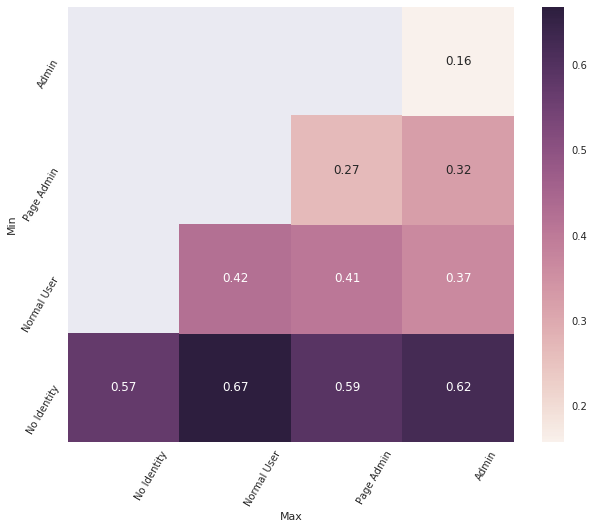

[[1166, 2314, 1198, 741], [0, 3575, 1305, 961], [0, 0, 2074, 450], [0, 0, 0, 1024]]


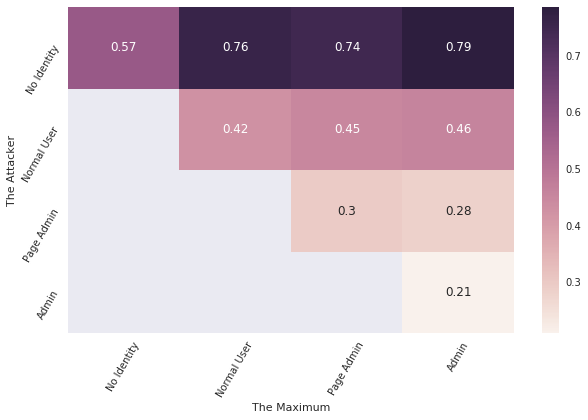

Number of conversations in the group: [5419, 5841, 2524, 1024]


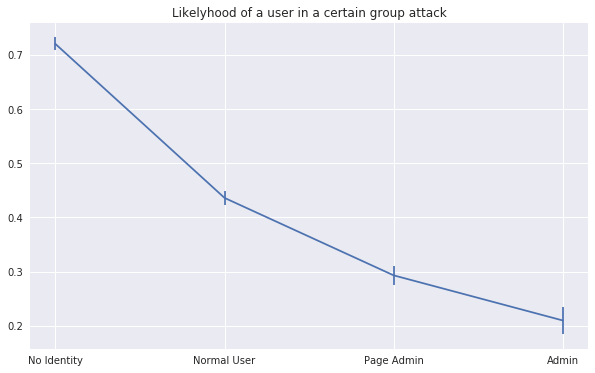

In [63]:
aspect = 'status'
tiles = [0, 1, 2, 4]
tile_legends = ['No Identity', 'Normal User', 'Page Admin', 'Admin']
data, nn, na = discrepancy_heatmap_status(aspect, feature_sets, tiles, tile_legends)
#data = discrepancy_heatmap1(aspect, feature_sets, tiles, tile_legends)

the_attacker = propencity_of_attacking(aspect, user_infos, documents, tiles, tile_legends, feature_sets)
attacker_plot(the_attacker, tile_legends)


/home/yiqing/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


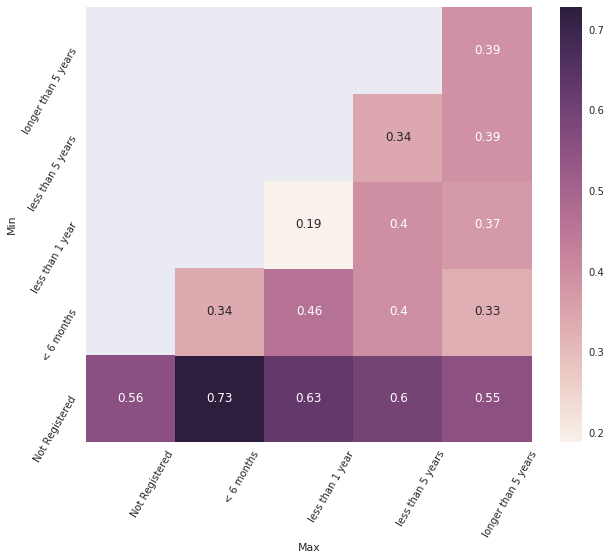

[[1119, 1014, 685, 2692, 405], [33, 787, 314, 869, 57], [44, 3, 623, 604, 39], [169, 15, 5, 3954, 328], [39, 11, 3, 8, 988]]


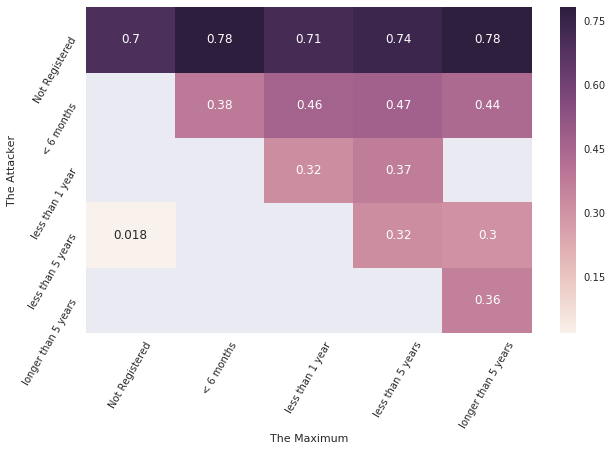

Number of conversations in the group: [5915, 2060, 1313, 4471, 1049]


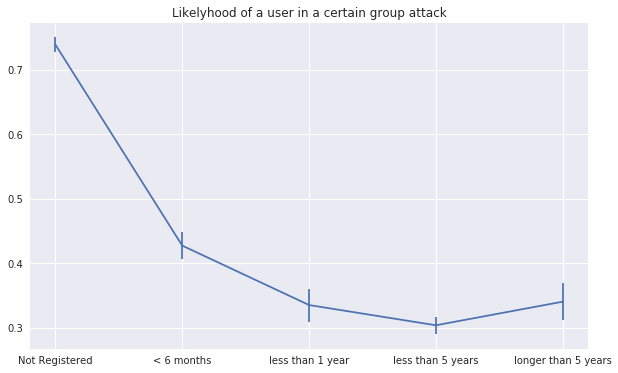

In [64]:
aspect = 'age'
v = get_values(aspect, feature_sets)
tiles = [0.000000001, 6, 12, 60, 180]
tile_legends = ['Not Registered', '< 6 months', 'less than 1 year', 'less than 5 years', 'longer than 5 years']
#discrepancy_heatmap(aspect, feature_sets, tiles, tile_legends)
discrepancy_heatmap(aspect, feature_sets, tiles, tile_legends)
the_attacker = propencity_of_attacking(aspect, user_infos, documents, tiles, tile_legends, feature_sets)
attacker_plot(the_attacker, tile_legends)

/home/yiqing/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


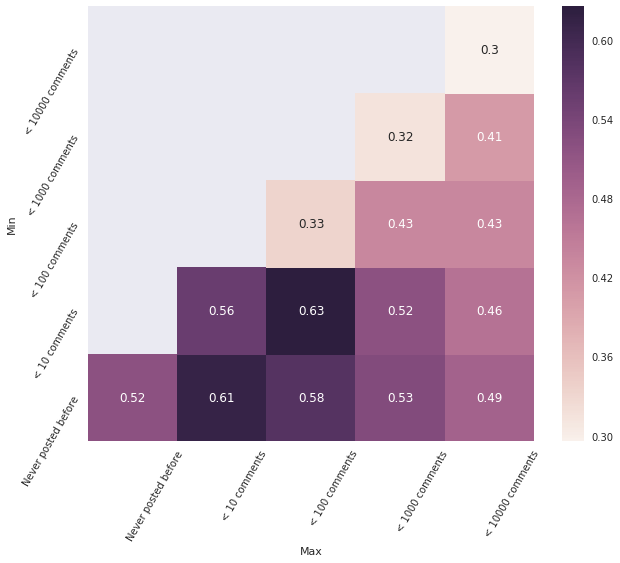

[[2546, 671, 1168, 1635, 644], [0, 657, 450, 689, 309], [0, 0, 1159, 786, 297], [0, 0, 0, 2417, 525], [0, 0, 0, 0, 855]]


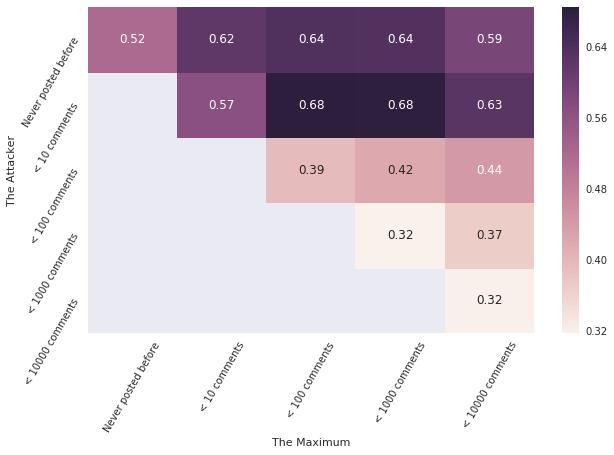

Number of conversations in the group: [6664, 2105, 2242, 2942, 855]


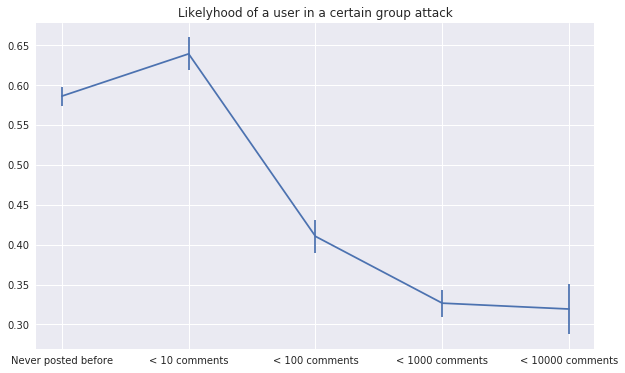

In [65]:
aspect = 'comments_on_all_talk_pages'
v = get_values(aspect, feature_sets)
tiles = [0.000000001, 10, 100, 1000, 100000]
tile_legends = ['Never posted before', '< 10 comments', '< 100 comments', '< 1000 comments', '< 10000 comments']
discrepancy_heatmap(aspect, feature_sets, tiles, tile_legends)
the_attacker = propencity_of_attacking(aspect, user_infos, documents, tiles, tile_legends, feature_sets)
attacker_plot(the_attacker, tile_legends)

/home/yiqing/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


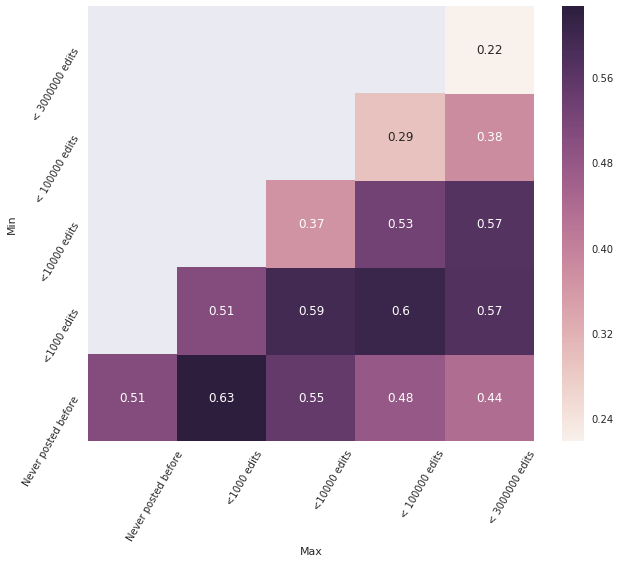

[[2491, 835, 882, 1385, 852], [0, 835, 344, 696, 453], [0, 0, 979, 592, 507], [0, 0, 0, 2125, 594], [0, 0, 0, 0, 1238]]


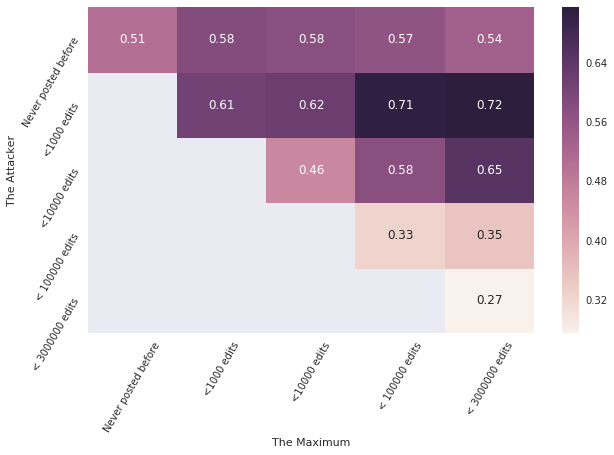

Number of conversations in the group: [6445, 2328, 2078, 2719, 1238]


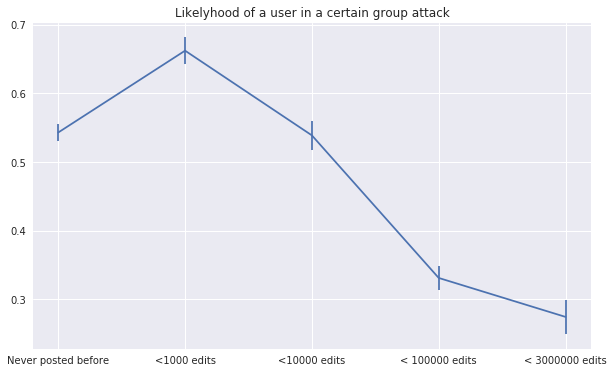

In [66]:
aspect = 'edits_on_wikipedia_articles'
v = get_values(aspect, feature_sets)
tiles = [0.000000001, 1000, 10000, 100000, 3000000]
tile_legends = ['Never posted before', '<1000 edits', '<10000 edits', '< 100000 edits', '< 3000000 edits']
discrepancy_heatmap(aspect, feature_sets, tiles, tile_legends)
the_attacker = propencity_of_attacking(aspect, user_infos, documents, tiles, tile_legends, feature_sets)
attacker_plot(the_attacker, tile_legends)

/home/yiqing/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


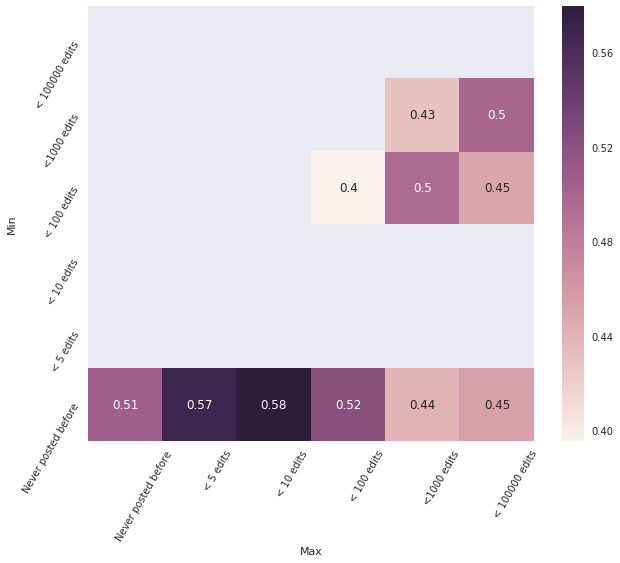

TypeError: propencity_of_attacking() missing 1 required positional argument: 'feature_sets'

In [67]:
aspect = 'edits_on_subjectpage'
v = get_values(aspect, feature_sets)
tiles = [0.000000001, 5, 10, 100, 1000, 100000]
tile_legends = ['Never posted before', '< 5 edits', '< 10 edits', '< 100 edits', '<1000 edits', '< 100000 edits']
discrepancy_heatmap(aspect, feature_sets, tiles, tile_legends)
propencity_of_attacking(aspect, user_infos, documents, tiles, tile_legends)

In [ ]:
aspect = 'comments_on_same_talk_page'
v = get_values(aspect, feature_sets)
tiles = [0.000000001, 5, 10, 250]
tile_legends = ['Never posted before', '< 5 comments', '< 10 comments', '> 10 comments']
discrepancy_heatmap(aspect, feature_sets, tiles, tile_legends)
propencity_of_attacking(aspect, user_infos, documents, tiles, tile_legends)

In [202]:
print(min(v),max(v), np.percentile(v, 25), np.percentile(v, 50), np.percentile(v, 75))

0 2450371 0.0 7364.0 55164.0


In [67]:
ASPECTS

['age',
 'status',
 'comments_on_same_talk_page',
 'comments_on_all_talk_pages',
 'edits_on_subjectpage',
 'edits_on_wikipedia_articles']

In [64]:
tiles

[0.0,
 0.0,
 0.0,
 4.0,
 30.0,
 84.0,
 171.0,
 345.0,
 662.0,
 1465.4000000000015,
 86090.0]

In [69]:
# Need to manually define tiles
aspect = ASPECTS[3]
tiles = discrepancy_heatmap(aspect, feature_sets, 5)
propencity_of_attacking(aspect, user_infos, documents, tiles, 5)

7 5 [0.0, 0.0, 30.0, 171.0, 662.0, 86090.0]


IndexError: list index out of range

# Plots and Examples

/home/yiqing/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


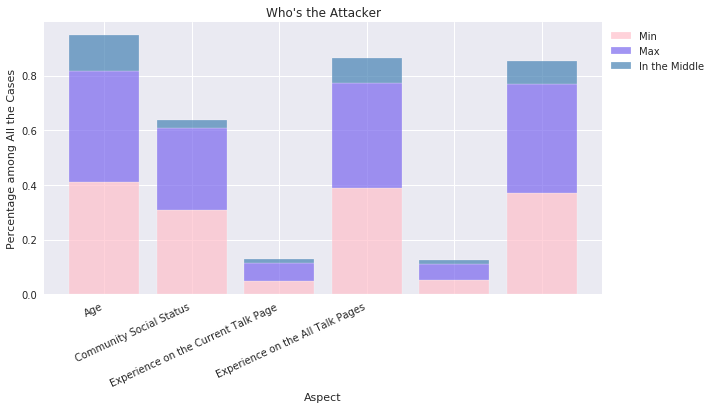

In [93]:
plot_profiles(profiles, 1, ASPECTS)

/home/yiqing/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


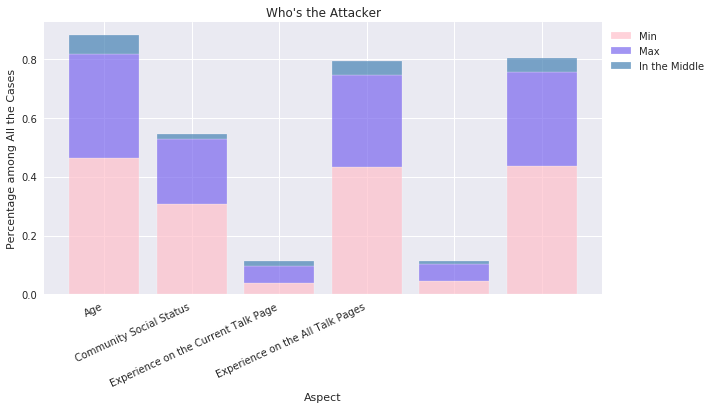

In [94]:
plot_profiles(profiles, 0, ASPECTS)

In [28]:
get_examples(documents, feature_sets, 'has_content_repeat', 1, 1, 1)

== the grim and frostbitten beginning == Here it is. It's mostly kinda minimal for now, since I've copied it all from 's pages and the parent project's pages. I haven't changed the colors yet though. That may be something to do later on. 
Navnløs
-1
ARGH! Grimmig und Erfroren!!!! I love it. I'm surprised we're even allowed to use an upside-down cross as our image thing. 
Navnløs
0
 :I have no idea if we actually are, but it was the first thing that came to my mind. We can change it if we get complaints, but I hope we won't because it's petty awesome.
5theye
1
 ::We can and will. If you get any Christian types complaining, send them towards [WP:CENSORED], and tell them [Cross of St. Peter@that they really need to learn a little about their own religion].
J Milburn
2
It is pretty awesome. J Milburn' is right about wikipedia not being censored and I realize the inverted cross is actually originally a Christian symbol (and still is; though uncommon), but it's obvious we're not using it tha

/home/yiqing/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


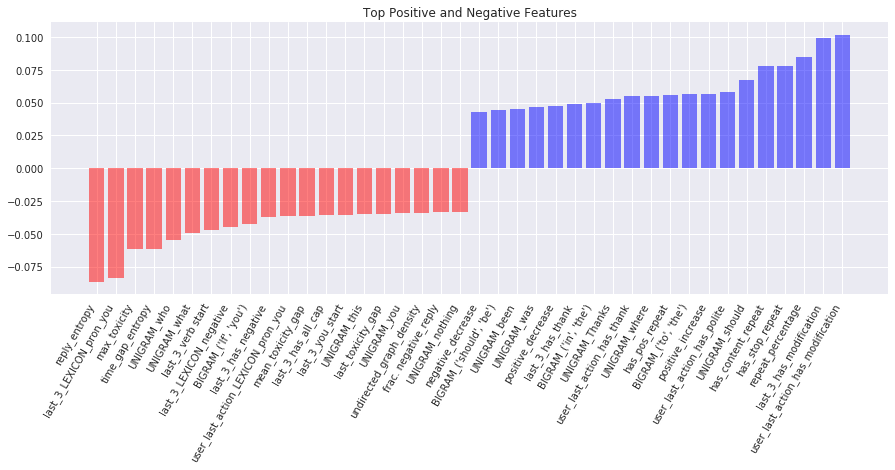

In [25]:
classifier = linear_model.LogisticRegression(C=0.003)
classifier.fit(X, y)
top_pos, top_neg= plot_coefficients(classifier, feature_names)
#0.630 (+/-0.007) for {'C': 0.0006}

finish collecting


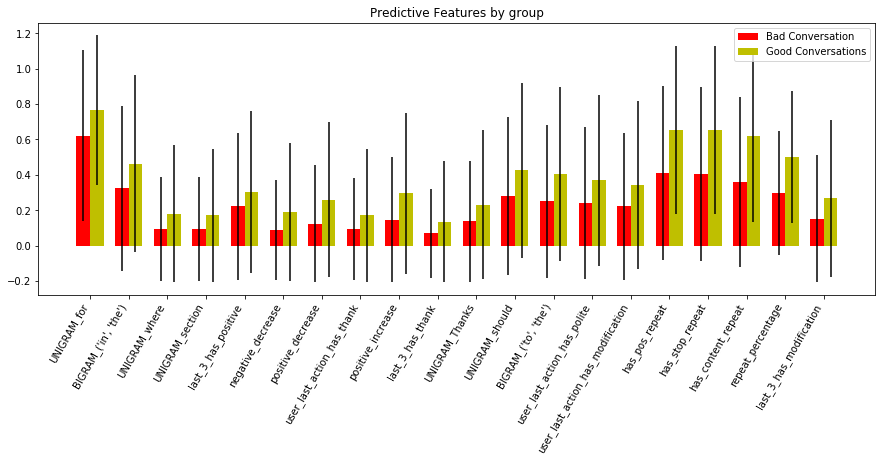

In [177]:
plot_feature_distribution(feature_sets, top_pos)

finish collecting


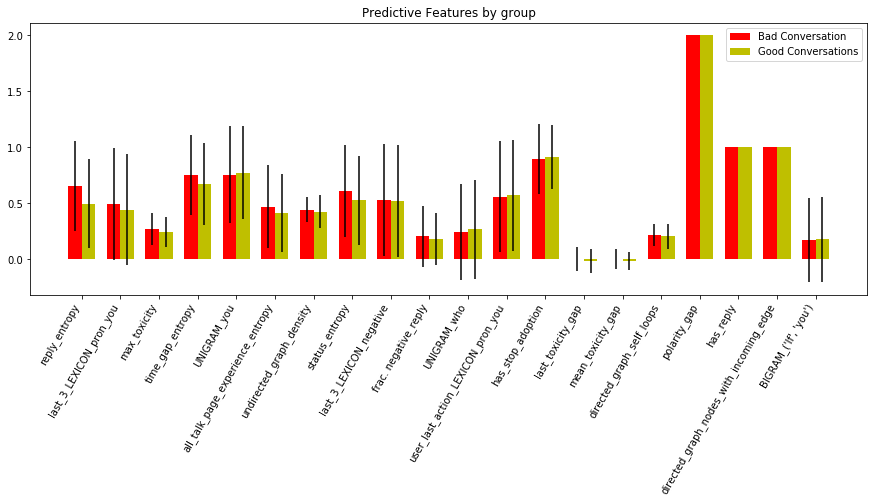

In [178]:
plot_feature_distribution(feature_sets, top_neg)

/home/yiqing/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


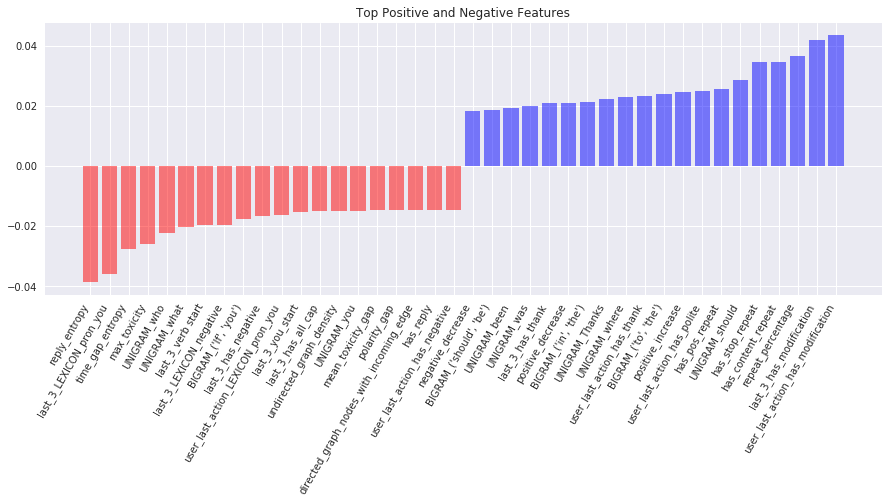

In [24]:
classifier = svm.LinearSVC(C=0.0003)
classifier.fit(X, y)
top_pos, top_neg = plot_coefficients(classifier, feature_names)
# bow + action(last 3 actions) + repeat + entropy
# 0.655 (+/-0.007) for {'C': 0.0006}

In [ ]:
# Output Feature Names

In [148]:
negative_features = {c:[] for c in constraints}
positive_features = {c:[] for c in constraints}

In [206]:
negative_features[constraint].append(yy)
positive_features[constraint].append(xx)

In [209]:
for n in negative_features.keys():
    negative_features[n] = negative_features[n][0]

In [210]:
for n in positive_features.keys():
    positive_features[n] = positive_features[n][0]

In [211]:
pd.DataFrame.from_dict(negative_features).to_csv('feature_results_negative.csv', index=False)

In [212]:
pd.DataFrame.from_dict(positive_features).to_csv('feature_results_positive.csv', index=False)

# Spearman Correlation

In [874]:
corr = []
pval = []
names = []
for key in features_corr:
    x,p = spearmanr(number_users, features_corr[key])
    corr.append(x)
    pval.append(p)
    names.append(key)


N = len(corr)

ind = np.arange(N)  # the x locations for the groups
width = 0.5       # the width of the bars

#plt.subplots()
plt.figure(figsize=(15, 5))
plt.bar(ind, corr, width, color='green', alpha=0.5, yerr=pval)

# add some text for labels, title and axes ticks
plt.ylabel('Spearman Correlation')
plt.title('Spearman Correlation between graph features and number of users')
plt.xticks(ind, names, rotation=60, ha='right')
#ax.set_xticklabels(names)

plt.show()